# Test of principle:  $\nabla \times B = \mu_0 j$

## Import modules and functions

In [1]:
# # -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import glob
import re
from math import pi, sqrt

import pylab as pl
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import import_ipynb
import Module_Diagnostics as MD

from tempfile import mkdtemp
import os.path as path
import json

#import pdb
#pdb.set_trace()

importing Jupyter notebook from Module_Diagnostics.ipynb


## Plot parametering

In [2]:
# %matplotlib notebook

## Physics constants

## Choose run and time for analysis

In [4]:
Cluster = 'Zoidberg'
Cluster = 'Curie'
Cluster = 'Occ'
run_name = 'current_test'

time = 600
time = '%05d' % time    # Change the time to string format, needed by functions

filepath = '../' + Cluster + '/' + run_name + '/ncfiles/'
date = re.search('w_(.+?)_t', glob.glob(filepath+'Magw*_t'+time+'.nc')[0]).group(1)

print(date)

23_01_13


## Get data in Magw and Jsw

#### Clear local tmp folder

In [5]:
!rm -rf /tmp/*

rm: cannot remove '/tmp/snap.spotify': Operation not permitted
rm: cannot remove '/tmp/systemd-private-d05db260333b45ff9e088a2ddcdddd88-ModemManager.service-peLctJ': Operation not permitted
rm: cannot remove '/tmp/systemd-private-d05db260333b45ff9e088a2ddcdddd88-bolt.service-saO96X': Operation not permitted
rm: cannot remove '/tmp/systemd-private-d05db260333b45ff9e088a2ddcdddd88-colord.service-AAnZH8': Operation not permitted
rm: cannot remove '/tmp/systemd-private-d05db260333b45ff9e088a2ddcdddd88-fwupd.service-OmaP4y': Operation not permitted
rm: cannot remove '/tmp/systemd-private-d05db260333b45ff9e088a2ddcdddd88-rtkit-daemon.service-K4CXQg': Operation not permitted
rm: cannot remove '/tmp/systemd-private-d05db260333b45ff9e088a2ddcdddd88-systemd-resolved.service-8xA1MP': Operation not permitted
rm: cannot remove '/tmp/systemd-private-d05db260333b45ff9e088a2ddcdddd88-systemd-timesyncd.service-Xm0wSg': Operation not permitted


### Upload B and J

In [6]:
## Load B and X, Y, Z

# There might be some MemoryError. In that case, follow the guide:
# https://stackoverflow.com/questions/60563936/memoryerror-unable-to-allocate-3-78-gib-for-an-array-with-shape-802-842-1502
Magw = MD.import_data_3D(filepath, date, time, 'Magw')

x = np.array(Magw['x'])
y = np.array(Magw['y'])
z = np.array(Magw['z'])

cwp = Magw['c_omegapi']
gstep = Magw['gstep']

nx,  ny,  nz  = len(x), len(y), len(z)
# Location of the planet is defined in the .ncfiles as (x,y,z) = (0,0,0)
nx0, ny0, nz0 = ( int(np.where(abs(x)==min(abs(x)))[0]),
                  int(np.where(abs(y)==min(abs(y)))[0]), 
                  int(np.where(abs(z)==min(abs(z)))[0])  )
            
# Use memmap to alleviate RAM
# This stores big arrays on the disk, but in a way that still allows for most
# operations available on an np.array
file_Bx = path.join(mkdtemp(), 'Bx.dat')            
Bx = np.memmap(file_Bx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bx[:] = Magw['Bx']
file_By = path.join(mkdtemp(), 'By.dat')            
By = np.memmap(file_By, dtype='float32', mode='w+', shape=(nx,ny,nz))
By[:] = Magw['By']
file_Bz = path.join(mkdtemp(), 'Bz.dat')            
Bz = np.memmap(file_Bz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bz[:] = Magw['Bz']
del Magw
B = [Bx, By, Bz]


import netCDF4 as nc
file_Jcur  = 'Jcur' + '_' + date + '_t' + time + '.nc'
Jrefw = {}
f = nc.Dataset(filepath+file_Jcur,'r')

Liste = ['Jx', 'Jy', 'Jz']
for variable in Liste:
    f.variables[variable] = np.float32(f.variables[variable][:,:,:,])
print('Reading Jx...')
Jx = f.variables['Jx'][:,:,:].transpose(2, 1, 0)
Jx = np.flip(Jx, axis=0)
Jx = np.flip(Jx, axis=1)
Jrefw.update({'Jx' : Jx})
del(Jx)
print('Reading Jy...')
Jy = f.variables['Jy'][:,:,:].transpose(2, 1, 0)
Jy = np.flip(Jy, axis=0)
Jy = np.flip(Jy, axis=1)
Jrefw.update({'Jy' : Jy})
del(Jy)
print('Reading Jz...')
Jz = f.variables['Jz'][:,:,:].transpose(2, 1, 0)
Jz = np.flip(Jz, axis=0)
Jz = np.flip(Jz, axis=1)
Jrefw.update({'Jz' : Jz})
del(Jz)
print('Close file and return...')
f.close()

# Use memmap to alleviate RAM
# This stores big arrays on the disk, but in a way that still allows for most
# operations available on an np.array
file_Jrefx = path.join(mkdtemp(), 'Jrefx.dat')            
Jrefx = np.memmap(file_Jrefx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Jrefx[:] = Jrefw['Jx']
file_Jrefy = path.join(mkdtemp(), 'Jrefy.dat')            
Jrefy = np.memmap(file_Jrefy, dtype='float32', mode='w+', shape=(nx,ny,nz))
Jrefy[:] = -Jrefw['Jy']
file_Jrefz = path.join(mkdtemp(), 'Jrefz.dat')            
Jrefz = np.memmap(file_Jrefz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Jrefz[:] = Jrefw['Jz']
Jref = [Jrefx, Jrefy, Jrefz]

Importing Magw 3D from ../Occ/current_test/ncfiles/
Reading Bx...
Reading By...
Reading Bz...
Close file and return...
Reading Jx...
Reading Jy...
Reading Jz...
Close file and return...


### Compute J

In [7]:
gstep_bis = np.mean(x[1:]-x[:-1])

file_Jx = path.join(mkdtemp(), 'Jx.dat')        
Jx = np.memmap(file_Jx, dtype='float32', mode='w+', shape=(nx,ny,nz))
file_Jy = path.join(mkdtemp(), 'Jy.dat')     
Jy = np.memmap(file_Jy, dtype='float32', mode='w+', shape=(nx,ny,nz))
file_Jz = path.join(mkdtemp(), 'Jz.dat') 
Jz = np.memmap(file_Jz, dtype='float32', mode='w+', shape=(nx,ny,nz))

j = 1./(MD.µ*cwp*1000) # unit of J nA/m²
Jx[:], Jy[:], Jz[:] = j * MD.curl(gstep,  B)
           
J = [Jx, Jy, Jz]

In [8]:
print(gstep_bis)
print(gstep)

0.6
[0.6 0.6 0.6]


## Plots

In [9]:
dl = 7

Jx_slice_x = Jx[:,ny0-dl:ny0+dl,nz0-dl:nz0+dl].mean(axis=(1, 2))
Jrefx_slice_x = Jrefx[:,ny0-dl:ny0+dl,nz0-dl:nz0+dl].mean(axis=(1, 2))

Jy_slice_x = Jy[:,ny0-dl:ny0+dl,nz0-dl:nz0+dl].mean(axis=(1, 2))
Jrefy_slice_x = Jrefy[:,ny0-dl:ny0+dl,nz0-dl:nz0+dl].mean(axis=(1, 2))

Jz_slice_x = Jz[:,ny0-dl:ny0+dl,nz0-dl:nz0+dl].mean(axis=(1, 2))
Jrefz_slice_x = Jrefz[:,ny0-dl:ny0+dl,nz0-dl:nz0+dl].mean(axis=(1, 2))

Jx_slice_y = Jx[nx0-dl:nx0+dl,:,nz0-dl:nz0+dl].mean(axis=(0, 2))
Jrefx_slice_y = Jrefx[nx0-dl:nx0+dl,:,nz0-dl:nz0+dl].mean(axis=(0, 2))

Jy_slice_y = Jy[nx0-dl:nx0+dl,:,nz0-dl:nz0+dl].mean(axis=(0, 2))
Jrefy_slice_y = Jrefy[nx0-dl:nx0+dl,:,nz0-dl:nz0+dl].mean(axis=(0, 2))

Jz_slice_y = Jz[nx0-dl:nx0+dl,:,nz0-dl:nz0+dl].mean(axis=(0, 2))
Jrefz_slice_y = Jrefz[nx0-dl:nx0+dl,:,nz0-dl:nz0+dl].mean(axis=(0, 2))

Jx_slice_z = Jx[nx0-dl:nx0+dl,ny0-dl:ny0+dl,:].mean(axis=(0, 1))
Jrefx_slice_z = Jrefx[nx0-dl:nx0+dl,ny0-dl:ny0+dl,:].mean(axis=(0, 1))

Jy_slice_z = Jy[nx0-dl:nx0+dl,ny0-dl:ny0+dl,:].mean(axis=(0, 1))
Jrefy_slice_z = Jrefy[nx0-dl:nx0+dl,ny0-dl:ny0+dl,:].mean(axis=(0, 1))

Jz_slice_z = Jz[nx0-dl:nx0+dl,ny0-dl:ny0+dl,:].mean(axis=(0, 1))
Jrefz_slice_z = Jrefz[nx0-dl:nx0+dl,ny0-dl:ny0+dl,:].mean(axis=(0, 1))

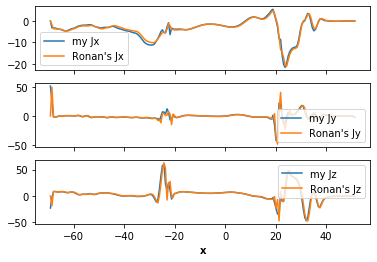

In [10]:
plt.figure()

ax1 = plt.subplot(311)
plt.plot(x, Jx_slice_x, label='my Jx')
plt.plot(x, Jrefx_slice_x, label="Ronan's Jx")
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend()

# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(x, Jy_slice_x, label='my Jy')
plt.plot(x, Jrefy_slice_x, label="Ronan's Jy")
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)
plt.legend()

# share x and y
ax3 = plt.subplot(313, sharex=ax1)
plt.plot(x, Jz_slice_x, label='my Jz')
plt.plot(x, Jrefz_slice_x, label="Ronan's Jz")
plt.xlabel('x', weight='bold')
plt.legend()

plt.show()


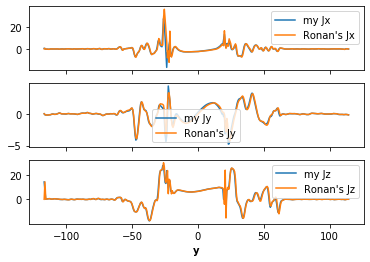

In [11]:
plt.figure()

ax1 = plt.subplot(311)
plt.plot(y, Jx_slice_y, label='my Jx')
plt.plot(y, Jrefx_slice_y, label="Ronan's Jx")
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend()

# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(y, Jy_slice_y, label='my Jy')
plt.plot(y, Jrefy_slice_y, label="Ronan's Jy")
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)
plt.legend()

# share x and y
ax3 = plt.subplot(313, sharex=ax1)
plt.plot(y, Jz_slice_y, label='my Jz')
plt.plot(y, Jrefz_slice_y, label="Ronan's Jz")
plt.xlabel('y', weight='bold')
plt.legend()

plt.show()


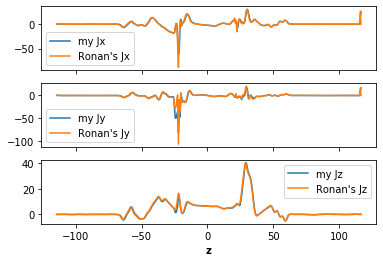

In [12]:
plt.figure()

ax1 = plt.subplot(311)
plt.plot(z, Jx_slice_z, label='my Jx')
plt.plot(z, Jrefx_slice_z, label="Ronan's Jx")
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend()
# share x 
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(z, Jy_slice_z, label='my Jy')
plt.plot(z, Jrefy_slice_z, label="Ronan's Jy")
plt.setp(ax2.get_xticklabels(), visible=False)
plt.legend()
ax3 = plt.subplot(313, sharex=ax1)
plt.plot(z, Jz_slice_z, label='my Jz')
plt.plot(z, Jrefz_slice_z, label="Ronan's Jz")
plt.xlabel('z', weight='bold')
plt.legend()

plt.show()

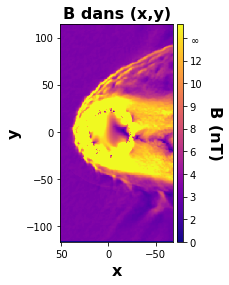

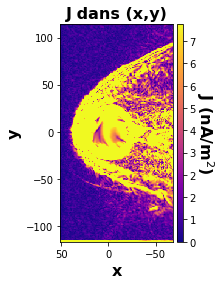

(<matplotlib.collections.PolyCollection at 0x7f81c544eac8>,)

In [16]:
plt.figure()

mag_B = MD.norm( [ Bx[:,:,nz0], By[:,:,nz0], Bz[:,:,nz0] ] )

MD.plot_colormap(mag_B, 'B dans (x,y)', 'B (nT)', 'xy')

plt.figure()

mag_J = MD.norm( [ Jx[:,:,nz0], Jy[:,:,nz0], Jz[:,:,nz0] ] )

MD.plot_colormap(mag_J, 'J dans (x,y)', r'J (nA/m$^2$)', 'xy'),